In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# handling data
import os
import json

In [4]:
ADAPTER_PATH = "adapter_tuning"
VANILLA_FINETUNING_PATH = "vanilla_finetuning"

# Functions for quicken things up

In [5]:
def get_trainer_state_data(path: str) -> pd.DataFrame:
    with open(path, "r") as f:
        trainer_state = json.load(f)
        log_history = trainer_state["log_history"]

    loss = []
    eval_loss = []
    lr = []
    eval_micro_f1 = []
    eval_macro_f1 = []

    for row in log_history:
        if "loss" in row:
            loss.append(row["loss"])
        if "eval_loss" in row:
            eval_loss.append(row["eval_loss"])
        if "learning_rate" in row:
            lr.append(row["learning_rate"])
        if "eval_micro-f1" in row:
            eval_micro_f1.append(row["eval_micro-f1"])
        if "eval_macro-f1" in row:
            eval_macro_f1.append(row["eval_macro-f1"])
        

    trainer_state_data = pd.DataFrame()
    trainer_state_data["loss"] = loss
    trainer_state_data["eval_loss"] = eval_loss
    trainer_state_data["learning_rate"] = lr
    trainer_state_data["eval_micro_f1"] = eval_micro_f1
    trainer_state_data["eval_macro_f1"] = eval_macro_f1

    return trainer_state_data

In [6]:
def get_model_training_data(
        training_type_path: str, 
        task: str
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
    task_path = os.path.join(training_type_path, task) 

    task_contents = os.listdir(task_path)
    checkpoints = [os.path.join(task_path, el) for el in task_contents if "checkpoint" in el]
    
    # selecting the best model and last model checkpoint
    checkpoint_no = {el: int(el.split("-")[-1]) for el in  checkpoints}

    if checkpoint_no[checkpoints[0]] < checkpoint_no[checkpoints[1]]:
        best_model_path = checkpoints[0]
        last_model_path = checkpoints[1]
    else:
        best_model_path = checkpoints[1]
        last_model_path = checkpoints[0]

    best_model_trainer_state_path = os.path.join(best_model_path, "trainer_state.json")
    last_model_trainer_state_path = os.path.join(last_model_path, "trainer_state.json")

    best_model_data = get_trainer_state_data(best_model_trainer_state_path)
    last_model_data = get_trainer_state_data(last_model_trainer_state_path)

    return best_model_data, last_model_data

In [7]:
def plot_loss_and_eval_loss(
        data: str,
        task_name: str,
        is_last: bool) -> None:
    if is_last:
        model_type = "letzten Checkpoints"
    else:
        model_type = "besten Checkpoints"

    plt.title(f"Loss und Evaluationsloss von {task_name} des {model_type}")
    plt.xlabel("Epoche")
    plt.ylabel("Loss")
    plt.plot(data["loss"], label="Loss")
    plt.plot(data["eval_loss"], label="Validations Loss")
    plt.legend()
    plt.show()

In [8]:
def plot_micro_and_macro_f1(
        data: pd.DataFrame,
        task_name: str,
        is_last: bool) -> None:
    if is_last:
        model_type = "letzten Checkpoints"
    else:
        model_type = "besten Checkpoints"

    plt.title(f"Mikro- und Makro-F1 von {task_name} des {model_type}")
    plt.xlabel("Epoche")
    plt.ylabel("F1")
    plt.plot(data["eval_micro_f1"], label="Mikro-F1")
    plt.plot(data["eval_macro_f1"], label="Makro-F1")
    plt.legend()
    plt.show()

In [9]:
def plot_compared_loss(
        vanilla_finetuning_data: pd.DataFrame,
        adapter_tuning_data: pd.DataFrame,
        task_name: str,
        type: str,
        path: str
        ) -> None:
    
    if type == "loss":
        plt.title(task_name)
        plt.xlabel("Epoche")
        plt.ylabel("Loss")
        plt.plot(vanilla_finetuning_data["loss"], label="Finetuning")
        plt.plot(adapter_tuning_data["loss"], label="Adapter Tuning")

    elif type == "eval_loss":
        plt.title(task_name)
        plt.xlabel("Epoche")
        plt.ylabel("Evaluationsloss")
        plt.plot(vanilla_finetuning_data["eval_loss"], label="Finetuning")
        plt.plot(adapter_tuning_data["eval_loss"], label="Adapter Tuning")

    else:
        print("Please enter a valid type!")
        return None

    plt.legend()
    plt.savefig(path)
    plt.show()

In [10]:
def plot_compared_f1(
        vanilla_finetuning_data: pd.DataFrame,
        adapter_tuning_data: pd.DataFrame,
        task_name: str,
        type: str,
        path: str
        ) -> None:
    if type == "micro_f1":
        plt.title(f"{task_name}")
        plt.xlabel("Epoche")
        plt.ylabel("F1")
        plt.plot(vanilla_finetuning_data["eval_micro_f1"], label="Finetuning")
        plt.plot(adapter_tuning_data["eval_micro_f1"], label="Adapter Tuning")

    elif type == "macro_f1":
        plt.title(f"{task_name}")
        plt.xlabel("Epoche")
        plt.ylabel("F1")
        plt.plot(vanilla_finetuning_data["eval_macro_f1"], label="Finetuning")
        plt.plot(adapter_tuning_data["eval_macro_f1"], label="Adapter Tuning")

    else:
        print("Please enter a valid type!")
        return None


    plt.legend()
    plt.savefig(path)
    plt.show()

In [11]:
def get_last_f1_value(data: pd.DataFrame, metric: str) -> int:
    if metric == "micro_f1":
        return data["eval_micro_f1"].iloc[-1]
    elif metric == "macro_f1":
        return data["eval_macro_f1"].iloc[-1]
    else:
        print("Please enter a valid metric!")
        return None

In [26]:
vf_test, _ = get_model_training_data(VANILLA_FINETUNING_PATH, "scotus")
at_test, _ = get_model_training_data(ADAPTER_PATH, "scotus")

In [41]:
def plot_compared_f1_barchart(
        vanilla_finetuning_data: pd.DataFrame,
        adapter_tuning_data: pd.DataFrame,
        task_name: str,
        metric: str,
        path: str,
        type: str,
        bar_width: float = 0.35
        ) -> None:
        
        if metric == "micro_f1" or metric == "macro_f1":
                vf_f1 = get_last_f1_value(vanilla_finetuning_data, metric)
                at_f1 = get_last_f1_value(adapter_tuning_data, metric)

                plt.xticks([0,bar_width], ("Finetuning", "Adapter Tuning"), rotation=45)
                plt.title(f"{metric} von {task_name} ({type})")
                plt.ylabel("F1")


                plt.bar([0], [vf_f1], width=bar_width)
                plt.bar([bar_width], [at_f1], width=bar_width)

        else:
                print("Please enter a valid metric!")
                return None

        plt.tight_layout()
        plt.savefig(path)
        plt.show()

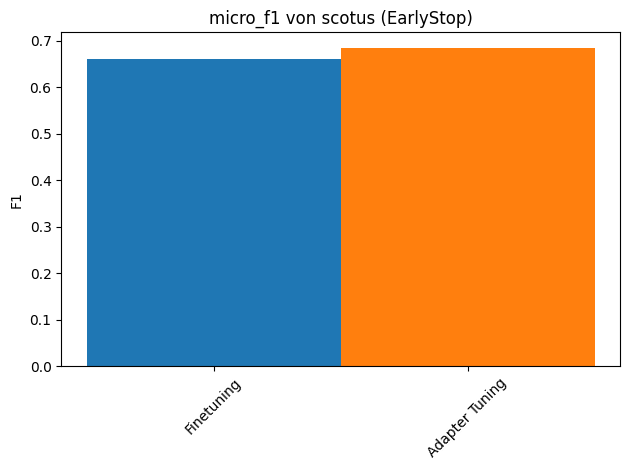

In [42]:
plot_compared_f1_barchart(vf_test, at_test, "scotus", "micro_f1", ".", "EarlyStop")

In [13]:
def get_last_epoch(data: pd.DataFrame) -> int:
    return data.iloc[-1].name

# Starting with Vanilla Finetuning

In [14]:
vf_tasks = os.listdir(VANILLA_FINETUNING_PATH)
vf_tasks.remove(".dockerignore")
vf_tasks.remove("Dockerfile")
vf_tasks.remove("requirements.txt")
vf_tasks.remove("src")
vf_tasks

['case_hold', 'ecthr_a', 'ecthr_b', 'eurlex', 'ledgar', 'scotus', 'unfair_tos']

In [15]:
bm_ch, lm_ch = get_model_training_data(VANILLA_FINETUNING_PATH, vf_tasks[0])
at_bm_ch, at_lm_ch = get_model_training_data(ADAPTER_PATH, vf_tasks[0])

## Last model

### Code for combining all subplots all together

In [16]:
from PIL import Image

def get_paths(
        metric: str,
        eval_type: str,
        subdir: str,
        )-> list[str]:
    
    path = os.path.join(subdir, metric)
    path = os.path.join(path, eval_type)

    tasks = os.listdir(path)
    return [os.path.join(path, el) for el in tasks]

In [17]:
def load_images(paths: str):
    return [Image.open(path) for path in paths]

In [18]:
def create_combined_plot(
        metric: str, 
        model_type: str,
        subdir: str,
        root_dir: str = "plots"):

    path = os.path.join(root_dir, subdir)
    paths = get_paths(metric, model_type, path)
    images = load_images(paths)


    fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(8, 8))

    axs[0, 0].imshow(images[0])  
    axs[0, 1].imshow(images[1])  

    axs[1, 0].imshow(images[2])  
    axs[1, 1].imshow(images[3])  

    axs[2, 0].imshow(images[4])  
    axs[2, 1].imshow(images[5])  

    axs[3, 0].imshow(images[6])  

    for ax in axs.flatten():
        ax.set_axis_off()

    fig.tight_layout()

    path = os.path.join(root_dir, subdir)
    path = os.path.join(path, metric)
    path = os.path.join(path, model_type)
    path = os.path.join(path, "all_combined")

    fig.savefig(path, dpi=300)
    fig.show()

# Let's compare the F1 for all datasets

In [19]:
def compare_metric(metric: str, model_type: str, root_dir: str = "plots") -> None:
    if not os.path.exists(root_dir):
        os.mkdir(root_dir)

    subdir = os.path.join(root_dir, "methods_comparison")
    if not os.path.exists(subdir):
        os.mkdir(subdir)

    folder_name = os.path.join(subdir, metric)
    if not os.path.exists(folder_name):
        os.mkdir(folder_name)    

    type_path = os.path.join(folder_name, model_type)
    if not os.path.exists(type_path):
        os.mkdir(type_path)


    for act_task in vf_tasks:
        print(act_task)
        path = os.path.join(type_path, act_task)
        if model_type == "best_model":
            vf_data, _ = get_model_training_data(VANILLA_FINETUNING_PATH, act_task)
            at_data, _ = get_model_training_data(ADAPTER_PATH, act_task)

        elif model_type == "last_model":
            _, vf_data = get_model_training_data(VANILLA_FINETUNING_PATH, act_task)
            _, at_data = get_model_training_data(ADAPTER_PATH, act_task)


        if metric == "micro_f1" or metric == "macro_f1":
            plot_compared_f1(vf_data, at_data, act_task, metric, path)
        elif metric == "loss" or metric == "eval_loss":
            plot_compared_loss(vf_data, at_data, act_task, metric, path)
        else:
            print(f"{metric} is not a valid metric!")
            return None
        

In [21]:
types = ["best_model", "last_model"]
metrics = ["micro_f1", "macro_f1", "loss", "eval_loss"]

for act_metric in metrics:
    for act_type in types:
        #compare_metric(act_metric, act_type)
        pass

paths:  ['0_plots\\methods_comparison\\micro_f1\\best_model\\case_hold.png', '1_plots\\methods_comparison\\micro_f1\\best_model\\ecthr_a.png', '2_plots\\methods_comparison\\micro_f1\\best_model\\ecthr_b.png', '3_plots\\methods_comparison\\micro_f1\\best_model\\eurlex.png', '4_plots\\methods_comparison\\micro_f1\\best_model\\ledgar.png', '5_plots\\methods_comparison\\micro_f1\\best_model\\scotus.png', '6_plots\\methods_comparison\\micro_f1\\best_model\\unfair_tos.png']
combined:  plots\methods_comparison\micro_f1\best_model\all_combined


C:\Users\stdemust\AppData\Local\Temp\ipykernel_4740\852440822.py:38: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


paths:  ['0_plots\\methods_comparison\\micro_f1\\last_model\\case_hold.png', '1_plots\\methods_comparison\\micro_f1\\last_model\\ecthr_a.png', '2_plots\\methods_comparison\\micro_f1\\last_model\\ecthr_b.png', '3_plots\\methods_comparison\\micro_f1\\last_model\\eurlex.png', '4_plots\\methods_comparison\\micro_f1\\last_model\\ledgar.png', '5_plots\\methods_comparison\\micro_f1\\last_model\\scotus.png', '6_plots\\methods_comparison\\micro_f1\\last_model\\unfair_tos.png']
combined:  plots\methods_comparison\micro_f1\last_model\all_combined
paths:  ['0_plots\\methods_comparison\\macro_f1\\best_model\\case_hold.png', '1_plots\\methods_comparison\\macro_f1\\best_model\\ecthr_a.png', '2_plots\\methods_comparison\\macro_f1\\best_model\\ecthr_b.png', '3_plots\\methods_comparison\\macro_f1\\best_model\\eurlex.png', '4_plots\\methods_comparison\\macro_f1\\best_model\\ledgar.png', '5_plots\\methods_comparison\\macro_f1\\best_model\\scotus.png', '6_plots\\methods_comparison\\macro_f1\\best_model\\un

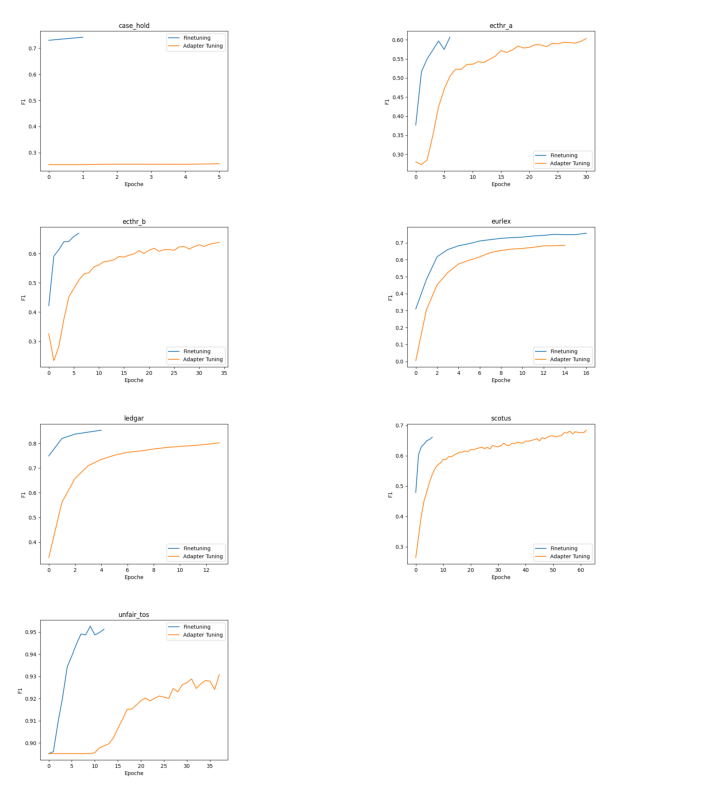

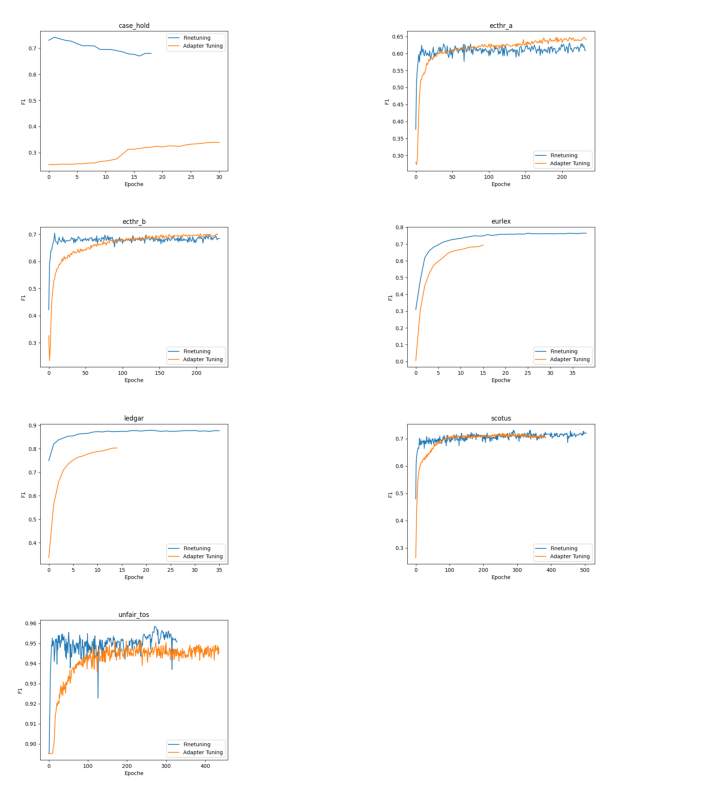

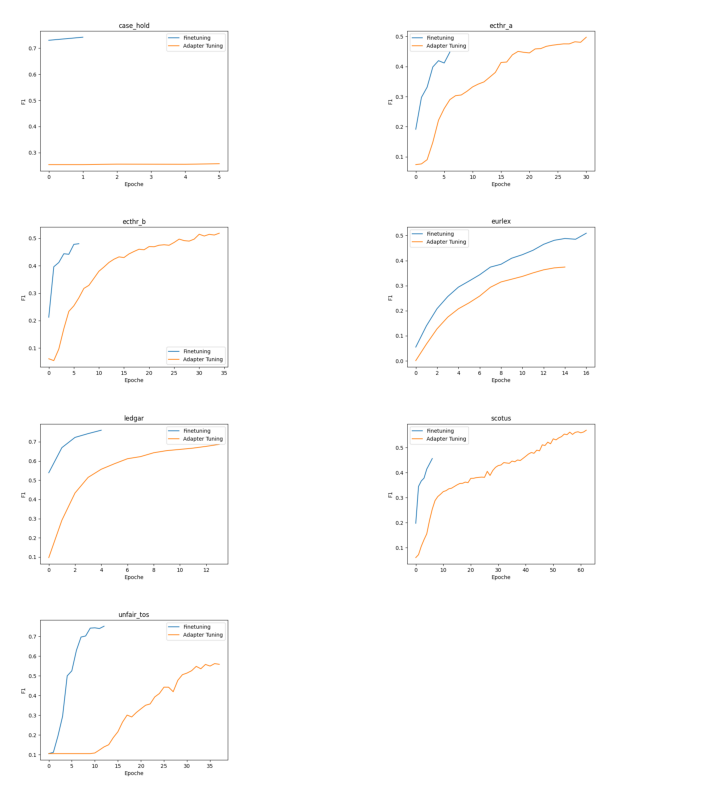

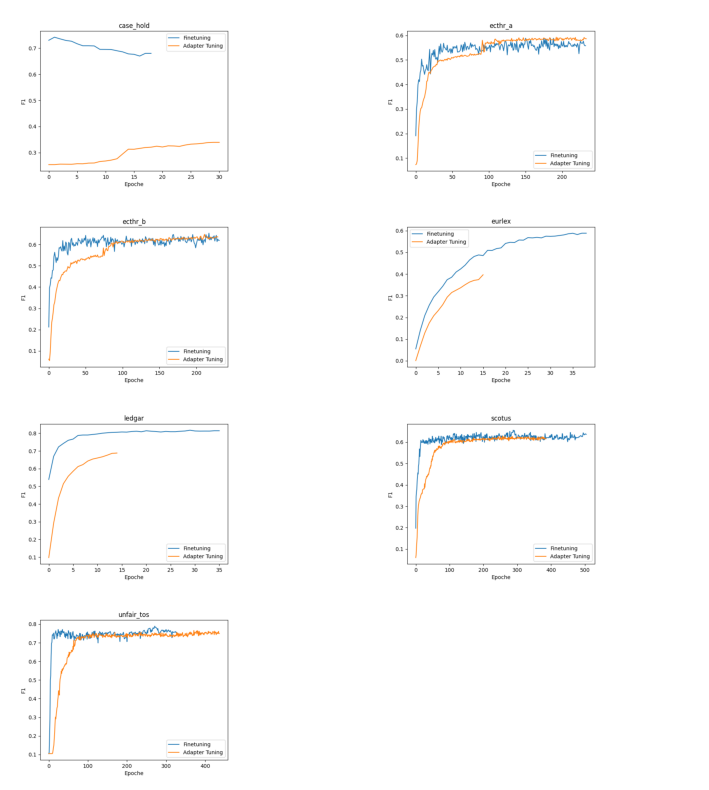

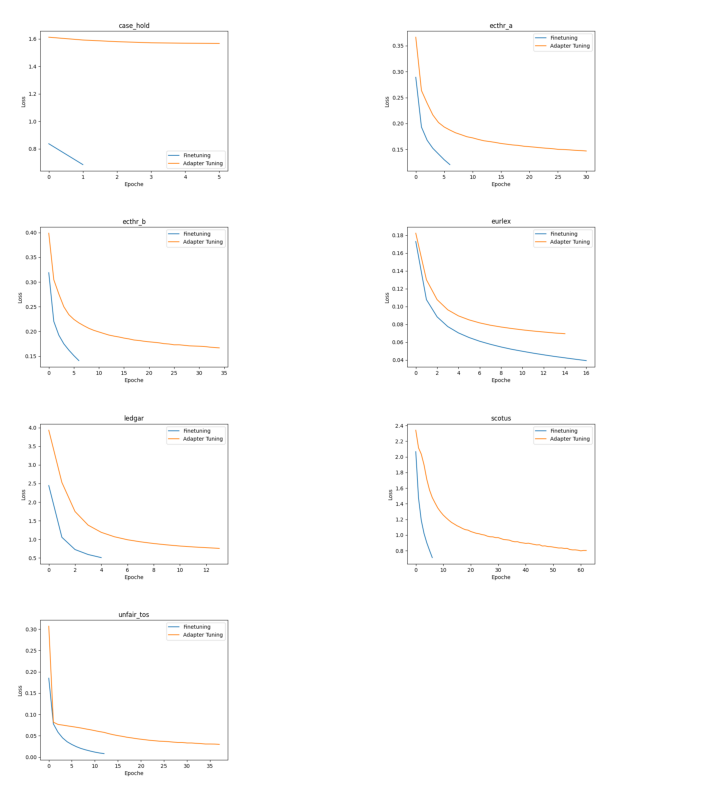

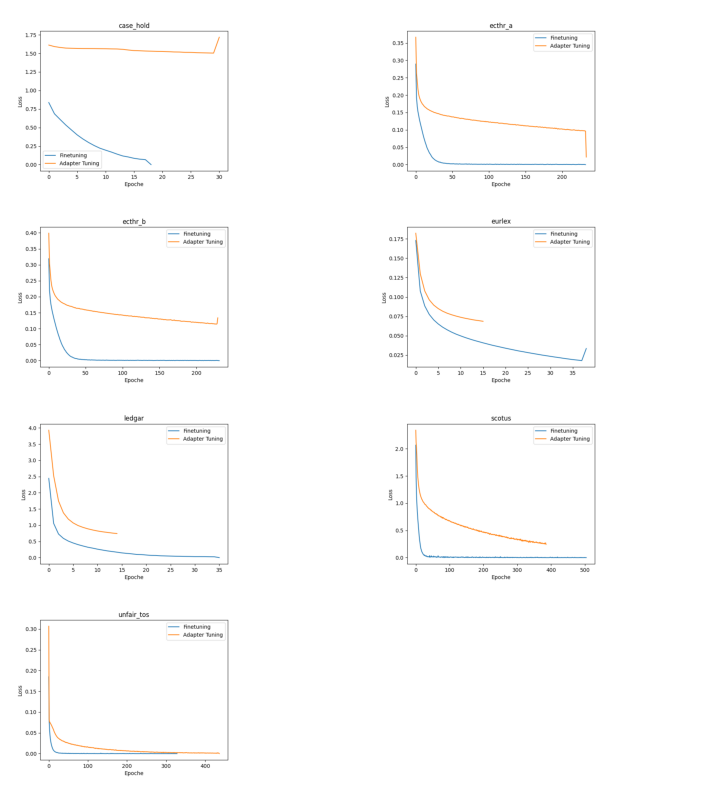

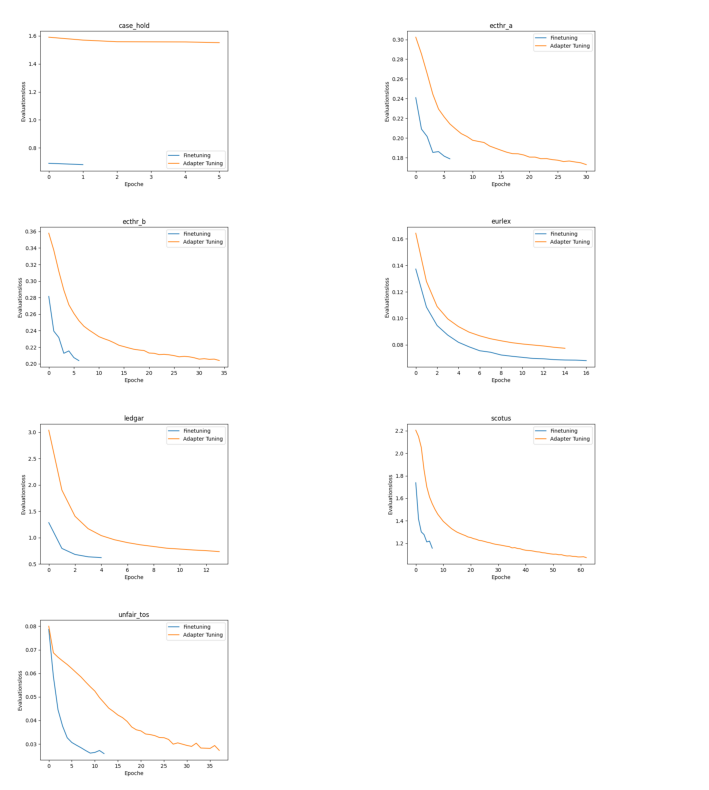

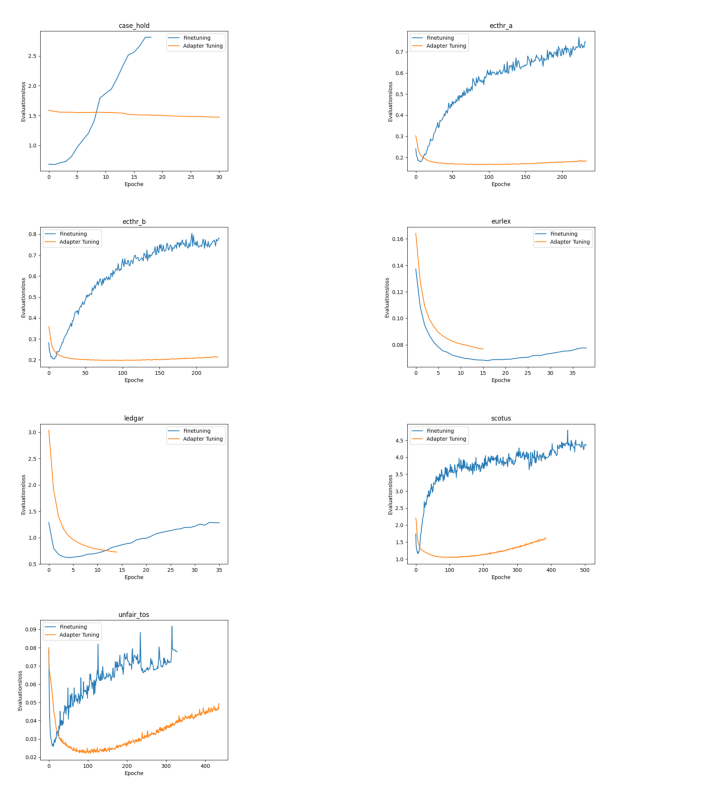

In [ ]:
for act_metric in metrics:
    for act_type in types:
#        create_combined_plot(act_metric, act_type, "methods_comparison")
        pass

## Compare all epochs

### Starting with best models

In [ ]:
vf_last_epochs = {}
at_last_epochs = {}

for act_task in vf_tasks:
    vf_best_model, _ = get_model_training_data(VANILLA_FINETUNING_PATH, act_task)
    at_best_model, _ = get_model_training_data(ADAPTER_PATH, act_task)
    vf_last_epochs[act_task] = get_last_epoch(vf_best_model)
    at_last_epochs[act_task] = get_last_epoch(at_best_model)


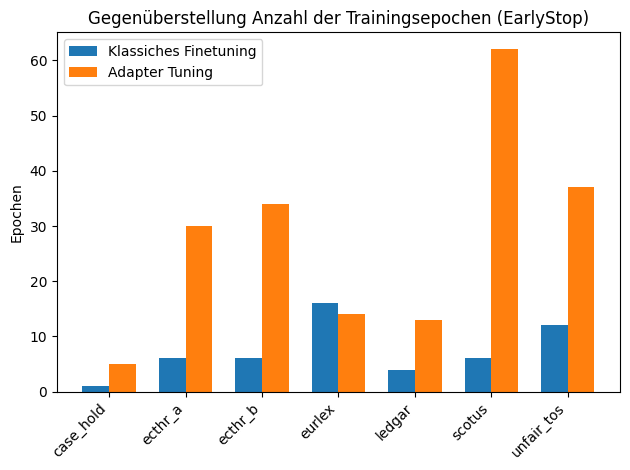

In [ ]:
def plot_comparison_epoch_amount(
                values1: dict, 
                values2:dict,
                type:str,
                bar_width: float = 0.35
                ) -> None:

    # Get the categories from the dictionaries
    categories = list(values1.keys())

    # Get the values from the dictionaries
    values1 = list(values1.values())
    values2 = list(values2.values())

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    x = np.arange(len(categories))

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the bars for the first category
    rects1 = ax.bar(x - bar_width/2, values1, bar_width, label='Klassiches Finetuning')

    # Plot the bars for the second category
    rects2 = ax.bar(x + bar_width/2, values2, bar_width, label='Adapter Tuning')

    # Set x-axis tick labels and positions
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')

    # Set y-axis label
    ax.set_ylabel('Epochen')

    # Set chart title
    ax.set_title(f'Gegenüberstellung Anzahl der Trainingsepochen ({type})')

    # Create a custom legend
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


plot_comparison_epoch_amount(vf_last_epochs, at_last_epochs, "EarlyStop")

In [49]:
def plot_comparison_f1(
                metric: str,
                type:str,
                path: str,
                bar_width: float = 0.35
                ) -> None:

    values1 = {}
    values2 = {}

    for act_task in vf_tasks:
        if type == "EarlyStop":
            vf_data, _ = get_model_training_data(VANILLA_FINETUNING_PATH, act_task)
            at_data, _ = get_model_training_data(ADAPTER_PATH, act_task)
        elif type == "24 Stunden":
            _, vf_data = get_model_training_data(VANILLA_FINETUNING_PATH, act_task)
            _, at_data = get_model_training_data(ADAPTER_PATH, act_task)

        values1[act_task] = get_last_f1_value(vf_data, metric)
        values2[act_task] = get_last_f1_value(at_data, metric)

    # Get the categories from the dictionaries
    categories = list(values1.keys())

    # Get the values from the dictionaries
    values1 = list(values1.values())
    values2 = list(values2.values())

    # Set the width of the bars
    bar_width = 0.35

    # Set the positions of the bars on the x-axis
    x = np.arange(len(categories))

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the bars for the first category
    rects1 = ax.bar(x - bar_width/2, values1, bar_width, label='Klassiches Finetuning')

    # Plot the bars for the second category
    rects2 = ax.bar(x + bar_width/2, values2, bar_width, label='Adapter Tuning')

    # Set x-axis tick labels and positions
    ax.set_xticks(x)
    ax.set_xticklabels(categories, rotation=45, ha='right')

    # Set y-axis label
    if metric == "micro_f1":
        ax.set_ylabel("Mikro-F1")
        ax.set_title(f'Gegenüberstellung Mikro-F1 ({type})')
    elif metric == "macro_f1":
        ax.set_title(f'Gegenüberstellung Makro-F1 ({type})')
        ax.set_ylabel("Makro-F1")


    # Create a custom legend
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.savefig(path, dpi=300)
    plt.show()

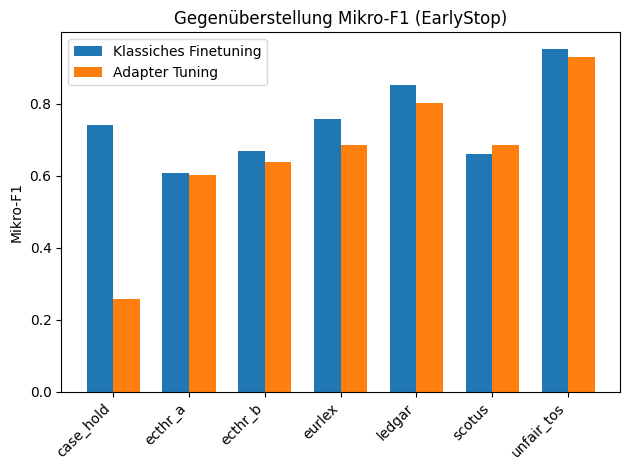

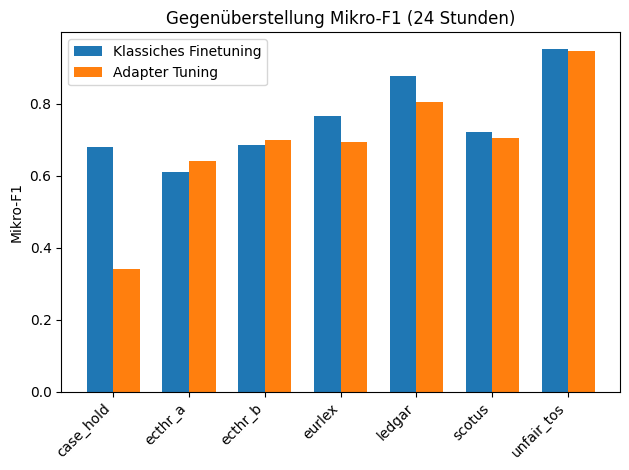

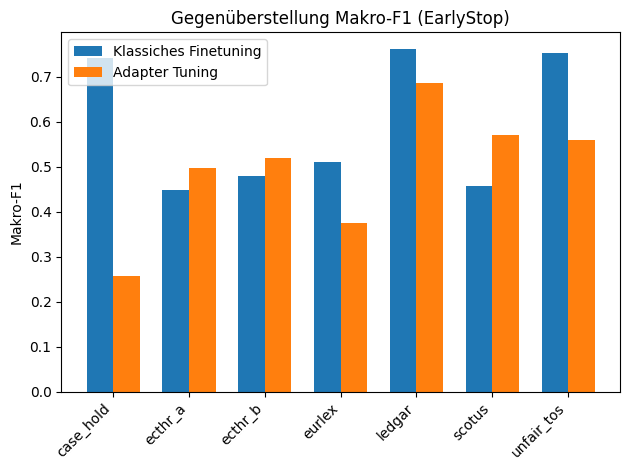

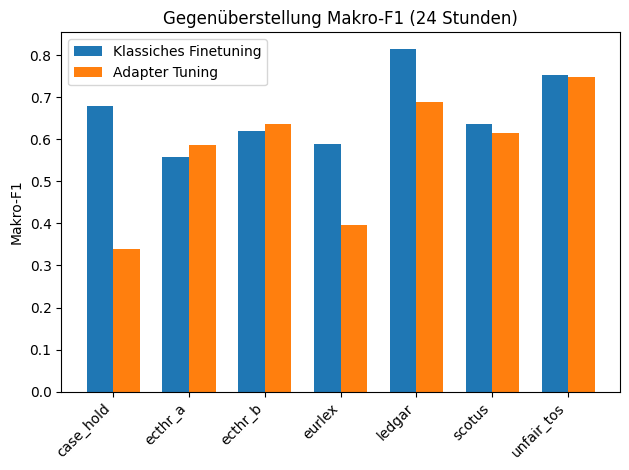

In [56]:
metrics = ["micro_f1", "macro_f1"]
types = ["EarlyStop", "24 Stunden"]

# creating directory
root_dir = os.path.join("plots", "methods_comparison")

for act_metric in metrics:
    for act_type in types:
        path = os.path.join(root_dir, act_metric) 
        if act_type == "EarlyStop":
            subdir_name = "best_model"
        else:
            subdir_name = "last_model"

        subdir_path = os.path.join(path, subdir_name) 
        file_path = os.path.join(subdir_path, "comparison_over_all_datasets") 
        plot_comparison_f1(act_metric, act_type, file_path)

In [52]:
def plot_single_comparison_epoch_amount(
        values1: dict, 
        values2: dict, 
        type: str,
        bar_width: float = 0.35
        ) -> None:

    # Combine the dictionaries into a single dictionary
    combined_values = {category: (values1[category], values2[category]) for category in values1}

    # Iterate over each data point
    for category, (value1, value2) in combined_values.items():
        # Create a figure and axis for each data point
        fig, ax = plt.subplots()
        
        # Plot the bars for the data point
        rects1 = ax.bar(x=[0], height=value1, width=bar_width, label='Value 1')
        rects2 = ax.bar(x=[bar_width], height=value2, width=bar_width, label='Value 2')
        
        # Set x-axis tick labels and positions
        ax.set_xticks([0, bar_width])
        ax.set_xticklabels(['Standard Finetuning', 'Adapter Tuning'])
        
        # Set y-axis label
        ax.set_ylabel('Epochen')
        
        # Set chart title
        ax.set_title(f'Anzahl Trainingsepochen von {category} gegenübergestellt ({type})')
        
        # Show the plot for the current data point
        plt.tight_layout()
        plt.show()

plot_single_comparison_epoch_amount(vf_last_epochs, at_last_epochs, "EarlyStop")

NameError: name 'vf_last_epochs' is not defined

### Continuing with the last models

In [ ]:
vf_last_epochs = {}
at_last_epochs = {}

for act_task in vf_tasks:
    _, vf_last_model = get_model_training_data(VANILLA_FINETUNING_PATH, act_task)
    _, at_last_model = get_model_training_data(ADAPTER_PATH, act_task)
    vf_last_epochs[act_task] = get_last_epoch(vf_last_model)
    at_last_epochs[act_task] = get_last_epoch(at_last_model)

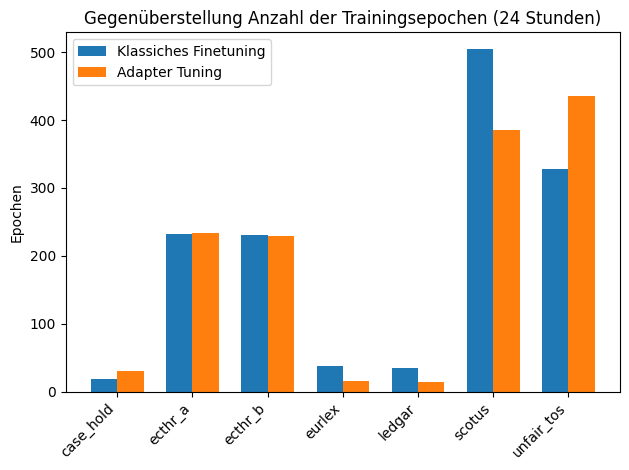

In [ ]:
plot_comparison_epoch_amount(vf_last_epochs, at_last_epochs, "24 Stunden")

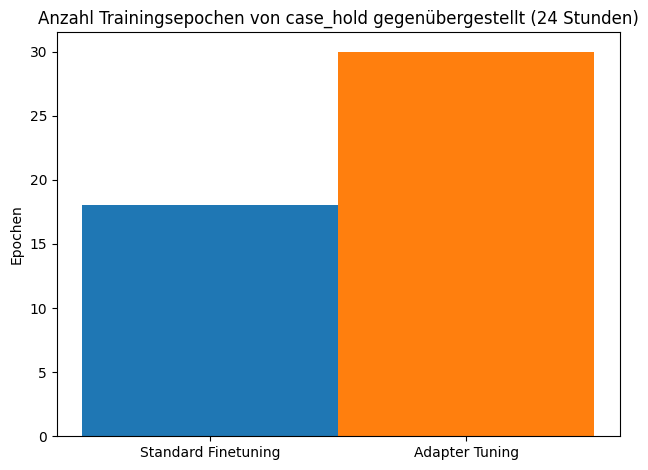

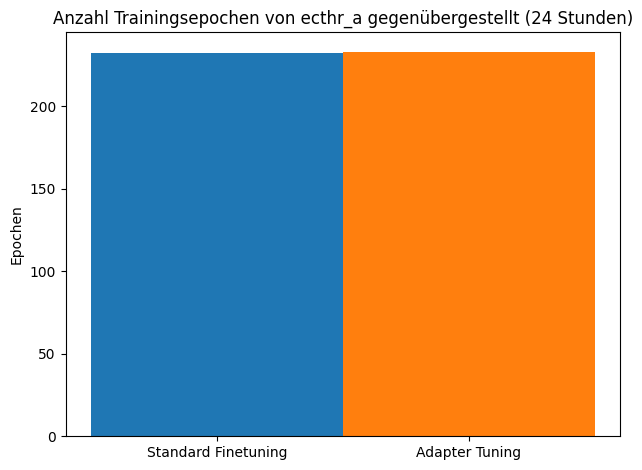

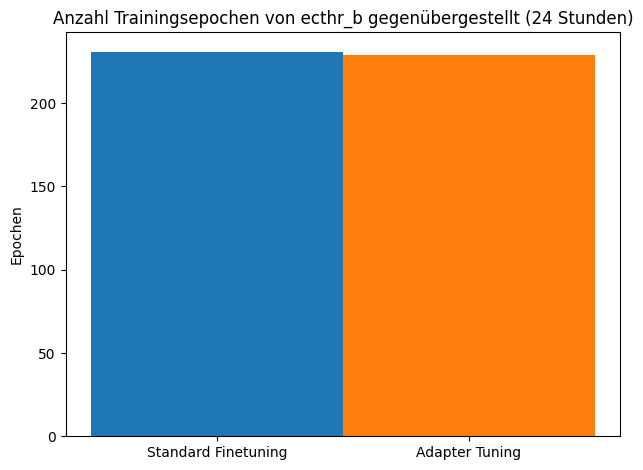

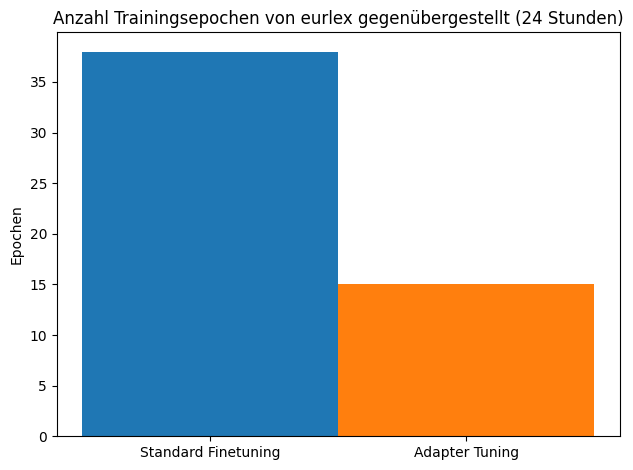

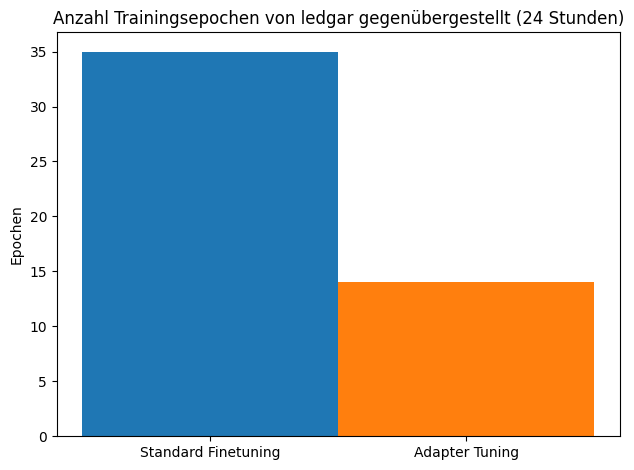

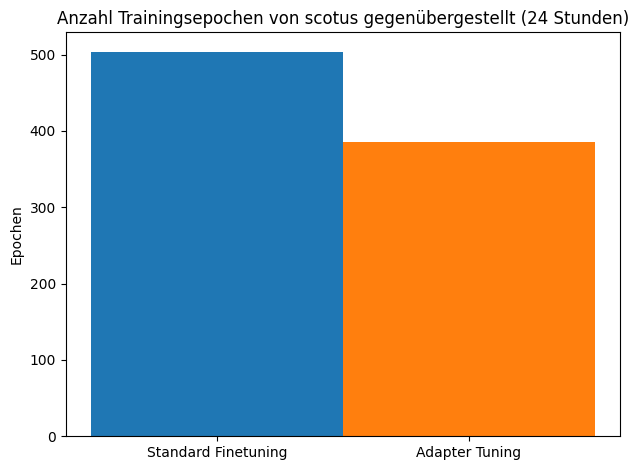

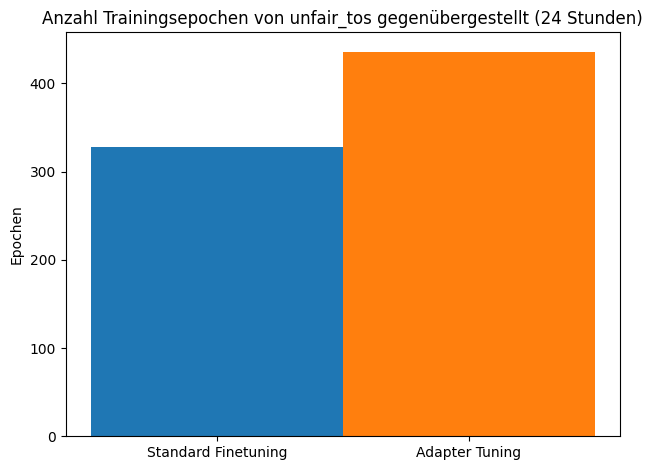

In [ ]:
plot_single_comparison_epoch_amount(vf_last_epochs, at_last_epochs, "24 Stunden")